Needed dependencies:

  * q-alchemy-sdk-py
  * jupyter
  * matplotlib
  * pandas
  * scikit-learn

In [1]:
import sys
import os
from threading import Thread

import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.circuit.library import Initialize

from q_alchemy.qiskit_integration import QAlchemyInitialize, OptParams

sys.path.append('..')
os.environ["Q_ALCHEMY_API_KEY"] = "<your api key>"

In [2]:
def plot_digits(digits, labels, matrix_dim, save_fig=None, fig_size=(20, 10)):
    fig, axes = plt.subplots(nrows=1, ncols=len(digits), figsize=fig_size, squeeze=False)
    for ax, digit, label in zip(axes.reshape(-1), digits, labels):
        ax.set_axis_off()
        image = digit[:int(matrix_dim**2)].reshape(matrix_dim, matrix_dim)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
        ax.set_title(label)
    if save_fig is not None:
        fig.savefig(save_fig)
    else:
        plt.show()
    plt.close(fig)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser="auto")

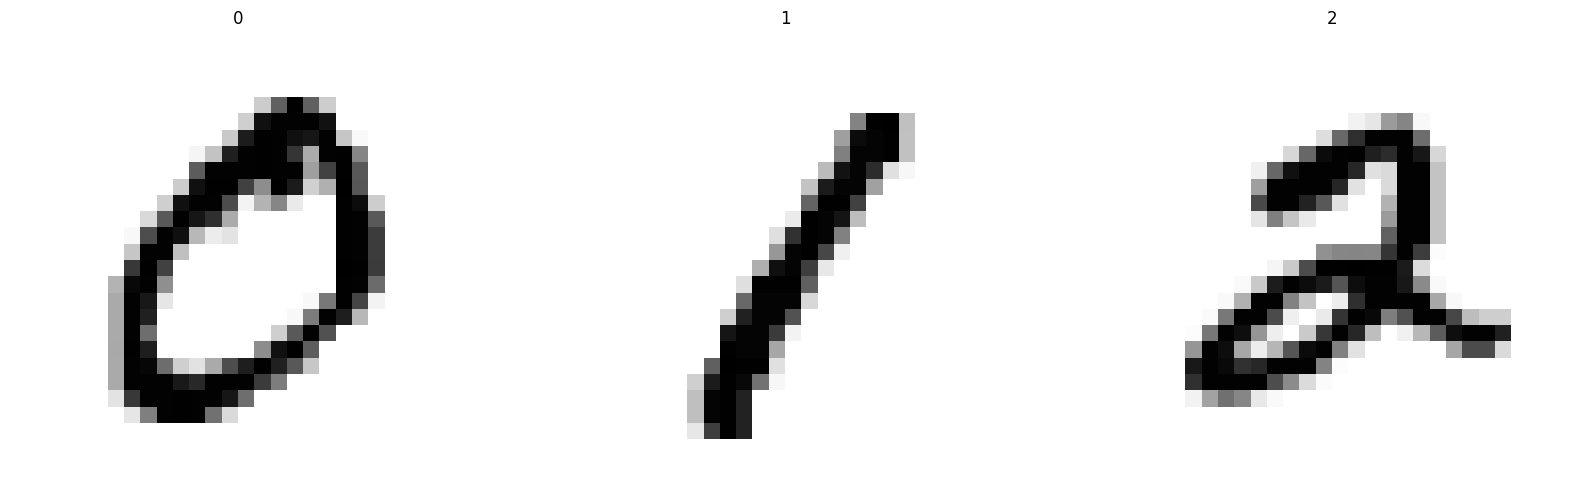

In [4]:
zero: np.ndarray = mnist.data[mnist.target == "0"].iloc[0].to_numpy()
one: np.ndarray = mnist.data[mnist.target == "1"].iloc[0].to_numpy()
two: np.ndarray = mnist.data[mnist.target == "2"].iloc[0].to_numpy()

filler = np.empty(2**10 - zero.shape[0])
filler.fill(0)

zero = np.hstack([zero, filler])
one = np.hstack([one, filler])
two = np.hstack([two, filler])

zero = zero / np.linalg.norm(zero)
one = one / np.linalg.norm(one)
two = two / np.linalg.norm(two)

plot_digits([zero, one, two], [0, 1, 2], 28)

In [5]:
# Here we start a job and you can check it out at the portal: 
# https://portal.q-alchemy.com/dashboard/jobs?ShowHidden=false

instr = QAlchemyInitialize(
    params=zero.tolist(), 
    opt_params=OptParams(
        max_fidelity_loss=0.1, 
        basis_gates=["id", "rx", "ry", "rz", "cx"],
        image_size=(28, 28),
        remove_data=False
    ))

In [6]:
instr.definition.draw(fold=-1)

C:\Users\CarstenBlank\Documents\qalchemy\q-alchemy-sdk-py\src\hypermedia_client\core\model\sirenmodels.py:107: UserWarning: Entity with extra properties received! Possibly a version mismatch between server and client? (unexpected properties: ['UsedStorageInBytes'])
  warnings.warn(
Version mismatch between 'hypermedia_client' (v5.0.0) and 'JobManagementAPI' (v5.1.1)! 
Version mismatch between 'hypermedia_client' (v5.0.0) and 'JobManagementAPI' (v5.1.1)! 


┌────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

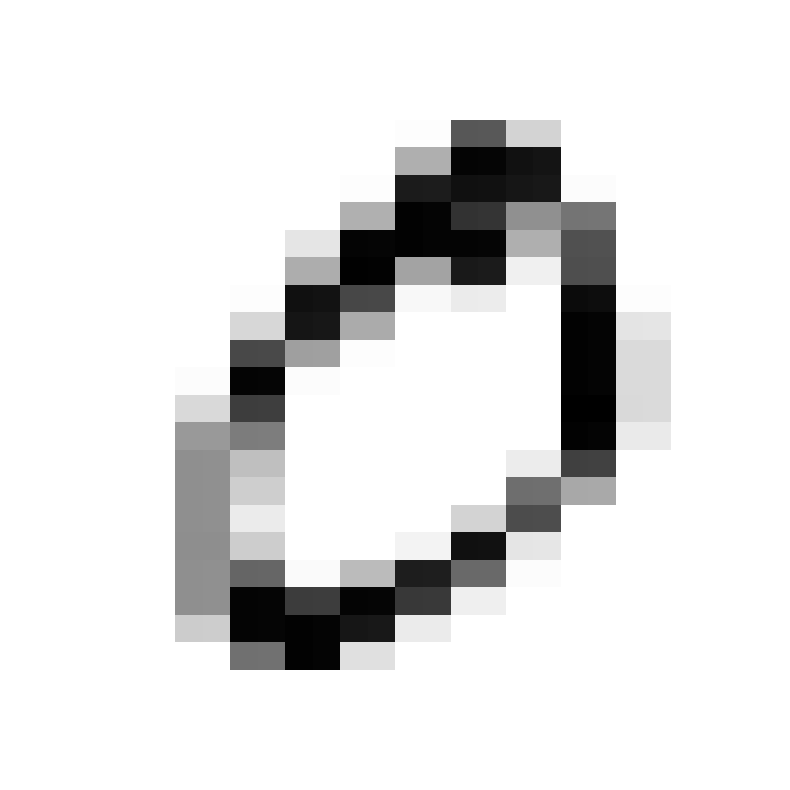

In [11]:
data = Statevector(instr.definition).data
data = np.real(data * data.conj())
plot_digits([data], [""], 28)

# Looking at the 0

In [8]:
def get_comparison_data(d: np.ndarray):
    
    print("Qiskit Benchmark")
    qs_org = Initialize(d.tolist())
    qs_qc = transpile(qs_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    state = Statevector(qs_qc).data.copy()
    state = np.real(state * state.conj())
    cx_length = len(qs_qc.get_instructions("cx"))
    
    threads = []
    result = [
        [-1.0, cx_length, state]
    ]
    for fidelity_loss in np.arange(0.0, 1.0, 0.025):
        def func(fl):
            fl = np.round(fl, decimals=3)
            sp_org = QAlchemyInitialize(
                params=d.tolist(),
                opt_params=OptParams(
                    max_fidelity_loss=fl, 
                    basis_gates=["id", "rx", "ry", "rz", "cx"],
                    image_size=(28, 28)
                )
            )
            print(f"Starting {fl}")
            qc = sp_org.definition
            sp_length = len(qc.get_instructions("cx"))
            sp_state = Statevector(qc).data.copy()
            sp_state = np.real(sp_state * sp_state.conj())
            print(f"Done {fl}")
            result.append([fl, sp_length, sp_state])
        job = Thread(target=func, args=(fidelity_loss,))
        job.start()
        threads.append(job)

    print(f"Waiting for {len(threads)} jobs to finish.")
    for x in threads: 
        x.join()
    
    return result

In [9]:
import pandas as pd

def plot_comparison(r):
    meta_data: np.ndarray = np.asarray([r[0:2] for r in r])
    sorting = meta_data[:, 0].argsort()
    meta_data = meta_data[sorting]
    
    image_data: np.ndarray = np.asarray([r[2] for r in r])
    image_data = image_data[sorting]
    
    labels = [f"{r[0]:.2f} @ {r[1]:n}cx" for r in meta_data]
    plot_digits(image_data, labels, 28)
    
    
def plot_comparison_v2(r, name="qa"):
    meta_data: np.ndarray = np.asarray([r[0:2] for r in r])
    sorting = meta_data[:, 0].argsort()
    meta_data = meta_data[sorting]
    
    image_data: np.ndarray = np.asarray([r[2] for r in r])
    image_data = image_data[sorting]
    
    os.makedirs("./mnist784_q-alchemy/", exist_ok=True)
    for meta, imag in zip(meta_data, image_data):
        plot_digits([imag], [""], 28, save_fig=f"./mnist784_q-alchemy/{name}_{meta[0]:.2f} @ {meta[1]:n}cx.svg")
        
    df = pd.DataFrame(
        data=meta_data,
        columns=["Fidelity Loss", "CX-Gate Count"]
    )
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), squeeze=True)
    df.plot.bar(x="Fidelity Loss", y="CX-Gate Count", ax=ax)
    fig.savefig(f"./mnist784_q-alchemy/{name}.svg")
    plt.close(fig)
    
    return df
        

In [12]:
result_zero = get_comparison_data(zero)

Qiskit Benchmark
Waiting for 40 jobs to finish.
Starting 0.075
Starting 0.05
Starting 0.125
Starting 0.475
Starting 0.025
Starting 0.65
Starting 0.375


C:\Users\CarstenBlank\Documents\qalchemy\q-alchemy-sdk-py\src\hypermedia_client\core\model\sirenmodels.py:107: UserWarning: Entity with extra properties received! Possibly a version mismatch between server and client? (unexpected properties: ['UsedStorageInBytes'])
  warnings.warn(


Starting 0.175
Starting 0.1
Starting 0.0
Starting 0.225
Starting 0.2
Starting 0.4
Starting 0.5
Starting 0.25
Starting 0.325
Starting 0.7
Starting 0.575
Starting 0.6
Starting 0.625
Starting 0.35
Starting 0.3
Starting 0.425
Starting 0.875
Starting 0.275
Starting 0.675
Starting 0.55
Starting 0.15
Starting 0.725
Starting 0.75
Starting 0.525
Starting 0.45
Starting 0.925
Starting 0.775
Starting 0.825
Starting 0.85
Starting 0.975
Starting 0.95
Starting 0.8
Starting 0.9


Exception in thread Thread-107 (func):
Traceback (most recent call last):
  File "C:\Users\CarstenBlank\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\CarstenBlank\Documents\qalchemy\q-alchemy-sdk-py\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\CarstenBlank\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\CarstenBlank\AppData\Local\Temp\ipykernel_5880\1849593309.py", line 29, in func
  File "C:\Users\CarstenBlank\Documents\qalchemy\q-alchemy-sdk-py\.venv\Lib\site-packages\qiskit\circuit\instruction.py", line 303, in definition
    self._define()
  File "C:\Users\CarstenBlank\Documents\qalchemy\q-alchemy-sdk-py\src\q_alchemy\qiskit_integration.py", line 127, in _define
    .select_processing(processing_step='convert_circuit_layers')
     ^^^^^^^^^^^

Done 0.025
Done 0.65
Done 0.05
Done 0.4
Done 0.475
Done 0.3
Done 0.7
Done 0.875
Done 0.575
Done 0.375
Done 0.625
Done 0.675
Done 0.2
Done 0.95
Done 0.325
Done 0.125
Done 0.45
Done 0.225
Done 0.925
Done 0.8
Done 0.85
Done 0.775
Done 0.35
Done 0.55
Done 0.725
Done 0.975
Done 0.425
Done 0.25
Done 0.825
Done 0.5
Done 0.75
Done 0.0
Done 0.1
Done 0.075
Done 0.15
Done 0.275


In [11]:
result_one = get_comparison_data(one)

Qiskit Benchmark
Starting 0.025


C:\Users\CarstenBlank\Documents\q-alchemy-sdk-py\src\hypermedia_client\core\model\sirenmodels.py:107: UserWarning: Entity with extra properties received! Possibly a version mismatch between server and client? (unexpected properties: ['UsedStorageInBytes'])
  warnings.warn(


Starting 0.0
Starting 0.075
Starting 0.05
Waiting for 40 jobs to finish.
Starting 0.175
Starting 0.325
Starting 0.275
Starting 0.225
Starting 0.35
Starting 0.25
Starting 0.1
Starting 0.2
Starting 0.125
Starting 0.3
Starting 0.375
Starting 0.15
Starting 0.575
Starting 0.55
Starting 0.6
Starting 0.425
Starting 0.675
Starting 0.45
Starting 0.525Starting 0.725
Starting 0.7
Starting 0.9
Starting 0.65
Starting 0.975

Starting 0.4
Starting 0.625
Starting 0.925
Starting 0.85
Starting 0.75
Starting 0.475
Starting 0.775
Starting 0.5
Starting 0.95
Starting 0.875
Starting 0.8
Starting 0.825
Done 0.025
Done 0.275
Done 0.325
Done 0.05
Done 0.3
Done 0.225
Done 0.25
Done 0.175
Done 0.575
Done 0.35
Done 0.375
Done 0.0
Done 0.075
Done 0.2
Done 0.125
Done 0.15
Done 0.1
Done 0.45
Done 0.8
Done 0.425
Done 0.55
Done 0.925
Done 0.975
Done 0.4
Done 0.9
Done 0.525
Done 0.625
Done 0.65
Done 0.825
Done 0.75
Done 0.6
Done 0.5
Done 0.775
Done 0.85
Done 0.875
Done 0.675
Done 0.7
Done 0.95
Done 0.475
Done 0.725


In [12]:
result_two = get_comparison_data(two)

Qiskit Benchmark
Starting 0.175Starting 0.225

Starting 0.275
Starting 0.25
Starting 0.15
Starting 0.45
Starting 0.2
Starting 0.5
Starting 0.475
Waiting for 40 jobs to finish.
Starting 0.55
Starting 0.525
Starting 0.575
Starting 0.1
Starting 0.85
Starting 0.825
Starting 0.75
Starting 0.875
Starting 0.8
Starting 0.325
Starting 0.775
Starting 0.0
Starting 0.125
Starting 0.35
Starting 0.375
Starting 0.025
Starting 0.425
Starting 0.05
Starting 0.4
Starting 0.3
Starting 0.075
Starting 0.625
Starting 0.675
Starting 0.6
Starting 0.725
Starting 0.925
Starting 0.9
Starting 0.65
Starting 0.7
Starting 0.975
Starting 0.95
Done 0.275
Done 0.175
Done 0.5
Done 0.45
Done 0.25
Done 0.225
Done 0.525
Done 0.2
Done 0.15
Done 0.55
Done 0.875
Done 0.575
Done 0.475
Done 0.8
Done 0.85
Done 0.375
Done 0.1
Done 0.775
Done 0.325
Done 0.825
Done 0.025
Done 0.75
Done 0.425
Done 0.125
Done 0.4
Done 0.6
Done 0.975
Done 0.0
Done 0.925
Done 0.3
Done 0.05
Done 0.675
Done 0.9
Done 0.625
Done 0.95
Done 0.65
Done 0.725
Do

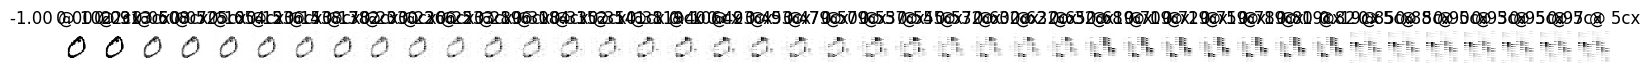

In [13]:
plot_comparison(result_zero)

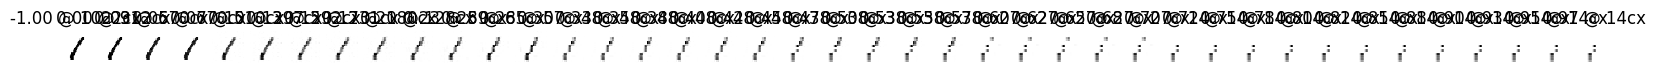

In [14]:
plot_comparison(result_one)

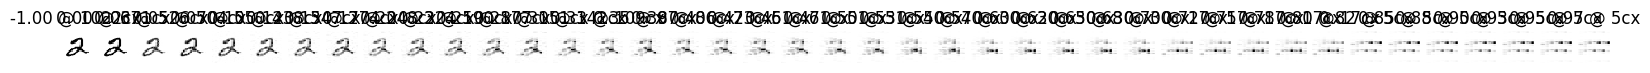

In [15]:
plot_comparison(result_two)

In [72]:
_ = plot_comparison_v2(result_zero, name="zero")

In [76]:
_ = plot_comparison_v2(result_one, name="one")

In [77]:
_ = plot_comparison_v2(result_two, name="two")